## Homework Three

In this assignment, you’ll deepen your grasp of linear regression by learning how to use a held-out test set to guide the selection of an appropriately-sized polynomial model—ensuring it captures real patterns without overfitting. By the end of this section, you’ll see firsthand how test-set performance offers a clear signal for choosing the right degree of polynomial. (Next week, we’ll build on this by introducing a separate validation set to fine-tune hyperparameters before final testing.)

In the second part, you’ll go beyond raw polynomial terms and explore feature engineering with non-linear transformations. You will create new predictors—such as log-scaled and interaction features—from the original inputs, then measure how these engineered variables can boost your model’s ability to explain and predict MPG.

There are 9 graded questions worth 5 points each, and you get 5 points free if you complete the homework. 

In [2]:
# Useful imports and utilities

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import kagglehub
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing,make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from tqdm import tqdm
from math import isclose

# globals

random_seed = 42       

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Problem One:  Model Selection for Polynomial Regression using Test Sets

This week’s video explores the challenge of model selection in polynomial regression: how do we determine the best polynomial degree for our data? As we saw, increasing model complexity (in this case, polynomial degree) generally reduces training MSE. However, this does not necessarily mean better generalization, so: 

- How do we select a model that performs well on new data?
- How do we strike the right balance between:
   - Underfitting (high bias, low variance), and
   - Overfitting (low bias, high variance)?

To address this, we introduce **testing sets** and examine how evaluating models on unseen data provides a more reliable measure of generalization. 

### Prelude

The following function will generate datasets suitable for polynomial regression with various characteristics:

- `n_samples`: number of samples
- `degree`: degree of the underlying polynomial model (with no noise)
- `noise`: standard deviation of the noise added to the model
- `show_data`, `show_model`: whether to show a plot of the dataset and the underlying model
- `random_state`: random seed which controls how random choices are made; set to None if you want a different set of choices each time

Your first task, as usual, is to play around with this a bit, changing the parameters in the cell where the function is called. There is no coding to be done (yet). 

In [3]:
# The polynomials

def f(x,degree):
    if degree==2:
        return 0.125*x**2 - 0.95*x + 1.925 
    elif degree==3:
        return 0.125*x**3 - 1.2*x**2 + 3*x + 0.5   
    elif degree==4:
        return 0.41*x**4 - 5.99*x**3 + 30.55*x**2 - 62.37*x + 41.4
    elif degree==5:
        return  -0.4*x**5 + 7.0*x**4 - 46.17*x**3 + 142.0*x**2 - 200.43*x + 102.0 
    elif degree==6:
        return -0.5219*x**6 + 10.7724*x**5 - 87.6206*x**4 + 355.7914*x**3 - 751.5246*x**2 + 774.0203*x - 300.917
    else:
        print("Degree must be in range [2..6]")
        return None
            
def make_poly_model(n_samples=10, degree=4,noise=1.0, show_data=False, show_model=True,random_state=random_seed):
    
    lb,ub = 1,6
            
    X_all = np.linspace(lb,ub,1000)
    y_perfect_model = f(X_all,degree)

    np.random.seed(random_state)
    X = np.linspace(lb,ub,n_samples)             # evenly spaced samples for simplicity
    y = f(X,degree) + np.random.normal(0, noise,size=n_samples)

    # Plotting the scatter plot of the data 

    if show_data:
      
        plt.figure(figsize=(8, 5))
        plt.scatter(X, y, marker='.',label=f'{n_samples} Data Points; Noise std = {noise}')
        if show_model:
            plt.plot(X_all, y_perfect_model, label='Underlying Model without noise', linestyle='--',color='grey', alpha=0.5)
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title(f'Degree {degree} Polynomial Noisy Dataset')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    return X.reshape(-1,1),y

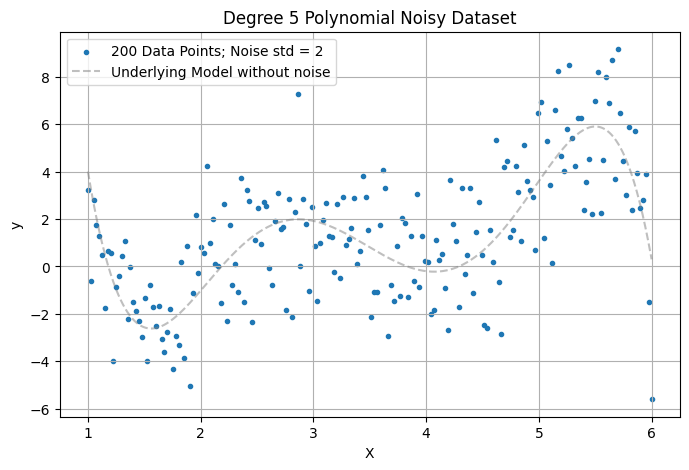

In [4]:
# Play around with various values here just to see what it does

X,y = make_poly_model(n_samples=200,degree=5,noise=2,show_data=True,random_state=None)

### Part A: Create a dataset with the following parameters:

    n_samples=200
    degree = 5
    noise=10
    random_state = random_seed

(leaving the others at the defaults) and then split it into the four usual sets using 
sklearn's `test_test_split` with 70% training and 30% test samples (`test_size=0.3`).

In [6]:
# Your code here
X,y = make_poly_model(n_samples=200,degree=5,noise=10,random_state=random_seed)
X_Train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=random_seed)

### Graded Question

Assign `a1a` to the number of samples (rows) in `X_train`. 

In [7]:
# Your answer here. Use an expression, not a constant from visual inspection.

a1a = X_Train.shape[0]                      # Replace 0 with an expression

In [8]:
# Do not change this cell in any way

print(f'a1a = {a1a}')

a1a = 140


### Part B: Investigating the model selection problem using test/train plots

In this part, you will complete the template below to:
- Train polynomial models of degree 1 .. 10 on the training dataset just produced in Part A;
- Calculate the training MSE and the testing MSE for each model;
- Plot the MSE curves vs the model degree (see the Appendix for an example plot); and
- Print out the minimal testing MSE found, and the "best" model which produced this result.
- Answer the graded question

In the remaining parts of the problem, you will answer questions about this plot. 


In [7]:
# Template for Problem One Part C

degrees = range(1,11) # try polynomials of these degrees
train_errors = []     # store training MSEs for each degree here
test_errors  = []     # store testing MSEs for each degree here

for d in degrees:

    pass             # remove: just to get the cell to run without error

    # Use PolynomialFeatures to transform the data into appropriate form for
    # a polynomial model of degree d.

        # Your code here

    # Fit a linear regression model on the transformed data

        # Your code here

    # Predict on the train and test sets

        # Your code here

    # Calculate the MSEs and append to the appropriate lists

        # Your code here

    
# Plot training and test MSEs vs degree of model using train_errors and test_errors
# Note that the x axis should have ticks for 1 .. 10 only

# Your code here

# Calculate and print out the minimal MSE for test set and degree where it was obtained 
# Hint: notice carefully that the MSE lists are for degrees [1, 2, 3, ....]  (i.e., index + 1)

# Your code here

### Graded Question

Set `a1b` to the minimum test MSE found for the given parameter choices.

In [8]:
# Your answer here. Use an expression, not a constant from visual inspection.

a1b = 0                      # Replace 0 with an expression

In [9]:
# Do not change this cell in any way

print(f'a1b = {a1b:.4f}')              

a1b = 0.0000


### For the last two parts of this problem, you must experiment with changes to the following parameters and observe what effect is produced in the plots in Part B:

- `n_samples`:  Try 10, 20, 50, 100, 200, 500, 1000
- `noise`: Try 0, 5, 10, 20, 50, 100, 500, 1000
- `random_state`: None           (then you can try multiple times with the same parameter choices)

It is sufficient for this problem to simply change each of these
separately, giving 7 + 8  = 15 trials. 

**Optional:**  For each parameter choice, try multiple times, with the random choices being different each time, by setting `random_state = None`. 

**RESET your answer to Part B back to the original parameters and then answer the following questions based on these experiments.  Alternately, add code cells and just copy the code necessary to do the experiments to avoid contaminating
your answers to Part A and B.** 



### Part C: Training MSE

Set the variable to the single **most correct** answer.

Throughout all your experiments, the training MSE curve in the plot in Part B appears to

1. Fluctuate unpredictably.
2. Never increase (gets smaller or stays the same in each step).
3. Decrease rapidly to degree 5 and then flatten out (not change much).
4. Always be higher than the test MSE.

In [10]:
# Your answer here. 

a1c = 0                    # Must be one of 1, 2, 3, 4

In [11]:
# Do not change this cell in any way

print(f'a1c = {a1c}')

a1c = 0


### Part D: Effect of No Noise 

If we leave all parameters the same as in our original Part B problem, **except** we set noise to 0, we will get the following plot, where the MSE is 0 for all degrees 5 and higher. 

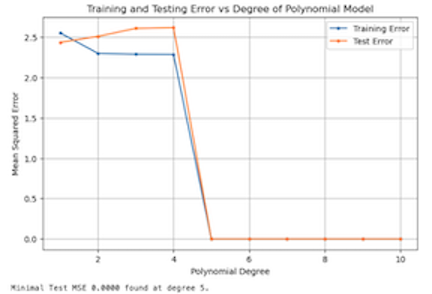

Why does the plot have MSE = 0 for degrees 5 and higher? Set the variable to the single **most correct** reason.

1. With noise set to zero, the training and test samples become identical, so any model (degree ≥ 5) will predict perfectly.
2. Ordinary least squares yields zero error whenever the number of model parameters equals the number of data points, which happens here for degree ≥ 5.
3. Removing noise makes the variance component of MSE disappear, causing the MSE to be zero for all models of degree 5 or above.
4. The degree-5 model exactly matches the true data-generating polynomial, and any higher-degree fit can simply set its extra coefficients to zero—so predictions are perfect on both training and test sets.

In [12]:
# Your answer here. 

a1d = 0                    # Must be one of 1, 2, 3, 4

In [13]:
# Do not change this cell in any way

print(f'a1d = {a1d}')

a1d = 0


### Part E: Effect of Increasing Amounts of Noise 

Suppose we leave all parameters the same as in our original Part B problem, **except** we set noise to increasingly larger values 0, 5, 10, 20, 50, 100, 500, 1000.

Set the variable to the single **most correct** answer regarding the plot. 

1. The best degree alternates between 5 and 6. 
2. The shapes of both plots is always essentially the same, the only change being the scale of the Y axis. 
3. The least MSE increases approximately proportionally to the square of the noise. 
4. The best degree found is always the same, and the least MSE increases approximately proportionally with the noise. 

In [14]:
# Your answer here. 

a1e = 0                    # Must be one of 1, 2, 3, 4

In [15]:
# Do not change this cell in any way

print(f'a1e = {a1e}')

a1e = 0


### Optional: Run more tests, with different degrees of polynomial as well!

If you have time to try more experiments, say by changing the degree, you will see that I chose the default parameters for our investigations
with some care, because you won't always get the beautiful curves shown in the testbooks, and you won't always get the correct degree when selecting
the "best" model based on the testing MSE. 

## Prelude to Problem Two

We have seen that it is possible to preprocess data by adding  new features which encode non-linear functions
of the existing features (in statistical learning theory, these are called "basis functions").  We have looked at only the simplest 
example, namely, extending a univariate regression problem with powers $x^2$, $x^3$, and so on. However, *basically* any non-linear function
of the features may be calculated and either added to, or replace, existing features. 

Examples of non-linear basis functions calculated from an existing feature $x$ and target $y$ include:

- **Polynomial Transforms** used in polynomial regression. In addition to new features such as $x^3$, when more than one feature occurs, we will get *Interaction Terms* such as $x_1x_2$. For example a quadratic polynomial regression on features $x_1$ and $x_2$ would create 3 new features: 
$$
y = \beta_0
+ \beta_1 x_1 + \beta_2 x_2
+ \beta_3 x_1^2 + \beta_4 x_2^2 + \beta_5 x_1 x_2
$$

- **Log Transforms** such as $\log(y)$ which (like using log scaling in a graph) helps scale a feature (or the target) if it ranges widely or exhibits exponential growth.

- **Exponentials** such as $2^{x_1}$ again helps scale a feature which exhibits exponential decay instead of exponential growth.

 

## Problem Two: Linear Regression with Feature Engineering on the MPG Dataset

In this problem, we use the **Auto MPG dataset**, which contains various attributes of cars such as horsepower, weight, and engine displacement, to predict **fuel efficiency (MPG)** using linear regression. This dataset includes both numerical and categorical features, and as the histograms show, several variables are skewed or span multiple orders of magnitude. To improve model performance, we will apply some **feature engineering** techniques before fitting a linear regression model.



In [16]:
# Load the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['mpg','cylinders','displacement','horsepower','weight',
                'acceleration','model_year','origin','car_name']
# df = pd.read_csv(url, delim_whitespace=True, names=column_names, na_values='?')
df_mpg = pd.read_csv(url, sep=r'\s+', names=column_names, na_values='?')

In [17]:
df_mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


**Hm... let's look at that last feature, looks categorical...**

In [18]:
df_mpg['car_name']

0      chevrolet chevelle malibu
1              buick skylark 320
2             plymouth satellite
3                  amc rebel sst
4                    ford torino
                 ...            
393              ford mustang gl
394                    vw pickup
395                dodge rampage
396                  ford ranger
397                   chevy s-10
Name: car_name, Length: 398, dtype: object

**And they are almost all unique--doesn't look very useful for our task!**

In [19]:
len(df_mpg['car_name'].unique())

305

**Now, as always, let's look at the histograms -- the categorical feature will be ignored...**

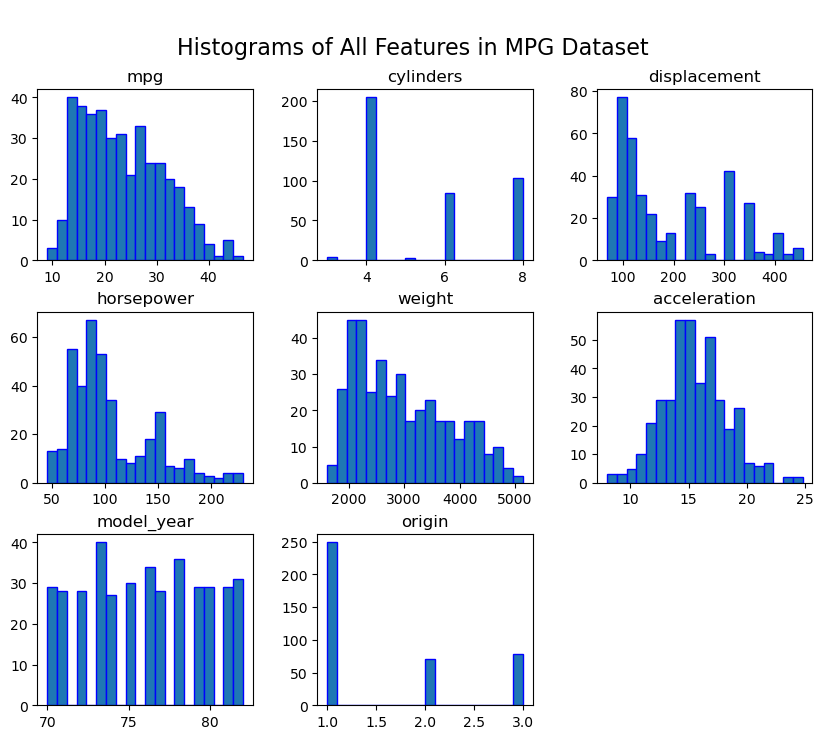

In [20]:
fig = df_mpg.hist(bins=20, figsize=(10, 8), layout=(3,3),grid=False,edgecolor='b')
plt.suptitle("\nHistograms of All Features in MPG Dataset", fontsize=16)
plt.show()

### Part A: Clean the Dataset

Before we can use the dataset for modeling, we need to address two issues:

1. **Irrelevant Categorical Feature**
   The `car_name` column is categorical, but most of its values are unique—305 distinct names in a dataset of 398 samples. This makes it an uninformative feature for modeling. Rather than encoding it, we will simply drop it.

2. **Missing Values in `horsepower`**
   Some entries in the `horsepower` column are missing. While it's possible to impute these values, we will take a simpler approach for now and remove any rows with missing data.

**TODO:**

* Create a new DataFrame called `df_mpg_cleaned` that:

  * Drops the `car_name` column.
  * Remove rows where the `horsepower` value is missing (`NaN`).
  * Do **not** modify the original DataFrame `df_mpg`.
* Check out the new dataset using `.info()`

Hint: You can actually do the cleaning in one line using Pandas chaining methods. But two lines are fine :-). 


In [21]:
# Your code here -- add additional cells if you wish


### Graded Question

Assign `a2a` to the number of data samples in the cleaned dataset.

In [22]:
# Your answer here. Use an expression, not a constant from visual inspection.

a2a = 0                      # Replace 0 with an expression

In [23]:
# Do not change this cell in any way

print(f'a2a = {a2a}')

a2a = 0


### Part B: Build and Evaluate a Baseline Linear Regression Model

In this part, you’ll build a baseline linear regression model to predict `mpg` from the cleaned dataset and evaluate its performance.

**TODO:**

1. **Define your features and target**

   * Use all columns **eXept** `mpg` as features (`X`).
   * Use the `mpg` column as the target (`y`).
   * Tip: It’s best to keep `y` as a DataFrame, not a Series.

2. **Split the data into training and test sets**

   * Use `train_test_split` from Scikit-learn.
   * Set the test size to 20% and use `random_state=random_seed` to ensure reproducibility.
   * This should give you `X_train`, `X_test`, `y_train`, and `y_test`.

3. **Fit a linear regression model**

   * Create and train a `LinearRegression` model using the training data.

4. **Generate predictions**

   * Predict MPG values for both the training and test sets.

5. **Evaluate the model**

   * Compute both **Root** Mean Squared Error (RMSE) and Mean Absolute Error (MAE) for the training and test sets.
   * Print all four metrics with appropriate labels.

6. **Visualize the training results**

   * Make a scatter plot of predicted vs. actual MPG for the **training set**.
   * Add labels and a title to your plot to make it clear what’s being shown.

7. ** Answer the graded questions**

>**Note:** If you examine your scatter plot carefully, you may notice that the points do not fall neatly along a straight line—especially at the low and high ends of the mpg scale. This suggests that the relationship between the features and the target is non-linear, and that applying some feature transformations could improve the model’s performance.


In [24]:
# Your code here; add as many cells as you need



### Graded Question

Assign `a2b` to the Test MAE just calculated. 

In [25]:
# Your answer here. Use an expression, not a constant from visual inspection.

a2b = 0                      # Replace 0 with an expression

In [26]:
# Do not change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.0000


### Part C: Build and evaluate a model with non-linear feature transformations

Now you must essentially repeat what you did in Part B, but after adding the following three engineered features 
to `X`. 

### Square-root transform of horsepower

The `horsepower` variable is right-skewed, with a long tail of high values. We apply a square-root transformation to reduce skewness and compress the scale of extreme values:

$$
    \text{SqrtHP} = \sqrt{\text{Horsepower}}
$$

This helps the model treat high-horsepower cars more smoothly without being dominated by a few large values.



### Log-transform of weight

Car weight ranges widely and is heavily skewed, as shown in the histogram. We add a log-transformed feature:

$$
    \text{LogWeight} = \log(1 + \text{Weight})
$$

This transformation preserves order but compresses extreme values, allowing the model to better capture the non-linear influence of weight on fuel efficiency. 

**Note:** $log(1 + x)$ (also known as `log1p(x)` in numpy) is a common transformation because it behaves well across both small and large values, and avoids the error associated with 0 values in the data. 



### Interaction term for displacement and cylinders

We hypothesize that the effect of engine displacement on MPG may depend on the number of cylinders, since larger engines typically have more cylinders. To model this interaction, we include:

$$
    \text{DispXyl} = \text{Displacement} \times \text{Cylinders}
$$

This allows the model to capture joint effects that wouldn’t be possible with separate linear terms.



**Note:** As in most modeling workflows, and **add** (not replace) new transformed features to enrich the model. In future lessons, we will explore how to evaluate the usefulness of these features and eliminate any that may add noise or redundancy.

**TODO:**

- Add these features to `X`
- Complete all steps from Part B, but for this new dataset
- Answer the graded question

In [27]:
# Your code here; add as many cells as you need



### Graded Question

Assign `a2c` to the Test RMSE just calculated. 

In [28]:
# Your answer here. Use an expression, not a constant from visual inspection.

a2c = 0                      # Replace 0 with an expression

In [29]:
# Do not change this cell in any way

print(f'a2c = {a2c:.4f}')

a2c = 0.0000


### Part D: Present your results

Finally, let's present this information in a useful way. 

**TODO:**

- Create a bar chart which shows the eight metrics and their relationship (it's ok to ask chatGPT to create the chart).

For each of the training metrics and the testing metrics:

- Calculate and print out the absolute improvement  of the baseline RMSE and the new feature-engineered RMSE
- Calculate and print out the absolute improvement  of the baseline MAE and the new feature-engineered MAE
- Calculate and print out the percent improvement  of the baseline RMSE and the new feature-engineered RMSE
- Calculate and print out the percent improvement of the baseline MAE and the new feature-engineered MAE

(you will have 8 measures of improvement)

- Answer the graded question
- 
---

**Hint:** Here are the calculations for these metrics. Suppose that 

* Baseline MAE = 5.00
* New MAE      = 4.00

then:

1. **Absolute improvement**

   $$
     \Delta\text{MAE} = \text{baseline\_MAE} - \text{new\_MAE}
                     = 5.00 - 4.00 = 1.0000
   $$

2. **Percent reduction**

   $$
     \%\text{Improvement}
     = \frac{\text{baseline\_MAE} - \text{new\_MAE}}{\text{baseline\_MAE}}
       \times 100
     = \frac{1.00}{5.00} = 0.2000
   $$



In [30]:
# Your code here; add as many cells as you need



### Graded Question

Assign `a2d` to the percent reduction in the Test MAE. 

In [31]:
# Your answer here. Use an expression, not a constant from visual inspection.

a2d = 0                      # Replace 0 with an expression

In [32]:
# Do not change this cell in any way

print(f'a2d = {a2d:.4f}')

a2d = 0.0000
